In [1]:
# Path to load files
file_path = "./final-ipynb"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score

%matplotlib inline

In [3]:
# Cargar datos de test
x_test, y_test = pickle.load(open(file_path+'/final_test.pkl', 'rb'))

# Diccionarios
saved_dict = pickle.load(open(file_path+'/saved_dict.pkl', 'rb'))
mode_dict = pickle.load(open(file_path+'/mode_dict.pkl', 'rb'))

# Standard scaler
scaler = pickle.load(open(file_path+'/scaler.pkl', 'rb'))

# Encoders one-hot
ohe_proto = pickle.load(open(file_path+'/ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'/ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'/ohe_state.pkl', 'rb'))

# El mejor modelo, es el Randomforest Classifier 
best_model = pickle.load(open(file_path+'/rf_best_clf.pkl', 'rb'))

In [4]:
#Limpieza de datos

def clean_data(data):

    #Elimina los valores nulos y erróneos 
    
    numerical_col = data.select_dtypes(include=np.number).columns 
    categorical_col = data.select_dtypes(exclude=np.number).columns
    
    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Sustituye los valores nulos por el valor modal
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"None" if x=="-" else x)

        # Si son binarias y el valor es >1 se sustituye por el valor modal
        if col in saved_dict['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Convertir columnas de tipo erróneo
    bad_dtypes = list(set(categorical_col) - set(saved_dict['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)
    
    return data

#Aplicar log1p

def apply_log1p(data):
    
    #Ejecuta el log1p, crea una nueva columna y elimina la original
    
    for col in saved_dict['log1p_col']:
        new_col = col + '_log1p'
        data[new_col] = data[col].apply(np.log1p)
        data.drop(col, axis=1, inplace=True)
    return data

#Estandarizar los valores

def standardize(data):
    
    #Estandariza las columnas numéricas
    
    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data


#Encoders one-hot para las columnas categóricas

def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))
    
    #Incluir las columnas con el encoder y eliminar las originales
    
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)
    
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)
    return data

In [5]:
#Funcion para realizar el preprocesamiento y las predicciones a partir de los datos

def final_fun_1(X):
   
    if isinstance(X, pd.core.series.Series):
        
        # Para una entrada puntual
        data = pd.DataFrame(X.values.reshape(1, -1)).copy()
    else:
        data = X.copy()
 

    data.reset_index(drop=True, inplace=True)
    data.columns = saved_dict['columns']


    dropable_col = saved_dict['to_drop'] + saved_dict['corr_col']
    data.drop(columns=dropable_col, inplace=True)

    data = clean_data(data)
    data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)

    
    # Realizar predicción con el modelo
    
    predictions = best_model.predict(data)
    
    return predictions

In [6]:
x_test.shape

(762015, 48)

In [7]:
# Para una entrada puntual

y_pred = final_fun_1(x_test.iloc[0])

In [8]:
y_pred, y_test.iloc[0]

(array([0]), 0)

In [9]:
# Para un conjunto de entradas

y_pred = final_fun_1(x_test.iloc[90:100])

In [10]:
print(y_pred)
print(y_test.iloc[90:100].values)

[0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 1 0 0]


In [11]:
# Para todo el conjunto de datos

y_pred = final_fun_1(x_test)

In [12]:
# Calculo de la puntuación f1 

f1_score(y_test.values, y_pred)

0.9769550631557529

In [13]:
x_test.shape

(762015, 48)

In [14]:
#Función para la realización de predición, evaluación y visualización de los resultados del modelo
def final_fun_2(X, Y):
    
    y_true = Y.copy() #Valores esperados
    y_pred = final_fun_1(X) #Predicciones

    # auc curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    # Confusion, precison and recall matrix
    C = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = C.ravel()
    FPR = fp / (fp + tn)
    FNR = fn / (fn + tp)

    P = (C/C.sum(axis=0))
    R =(((C.T)/(C.sum(axis=1))).T)

    # Scores of test dataset
    y_auc = auc(fpr, tpr)
    y_f1 = f1_score(y_true, y_pred)
    y_far = (FPR+FNR)/2  # False alarm rate

    # Visualización del resultado
    
    x = PrettyTable()
    x.field_names = ['AUC', 'F1-score', 'Tasa de falsa alarma']
    x.add_row([y_auc, y_f1, y_far])
    print(x)

    plt.figure(figsize=(12, 5))
    plt.plot(fpr, tpr, color='r', label=f"AUC: {y_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    labels= ['non-attack', 'attack']
    # Confusion
    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap="Blues", fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicción")
    plt.ylabel("Esperado")
    plt.title("Confusion Matrix")
    # Precision
    plt.subplot(1,3,2)
    sns.heatmap(P, annot=True, cmap="Greens", fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicción")
    plt.ylabel("Esperado")
    plt.title("Precision Matrix")
    # Recall
    plt.subplot(1,3,3)
    sns.heatmap(R, annot=True, cmap="BuPu", fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicción")
    plt.ylabel("Esperado")
    plt.title("Recall Matrix")
    plt.show()
    
    return y_auc, y_f1, y_far

+--------------------+--------------------+----------------------+
|        AUC         |      F1-score      | Tasa de falsa alarma |
+--------------------+--------------------+----------------------+
| 0.9856129417927407 | 0.9769550631557529 | 0.01438705820725936  |
+--------------------+--------------------+----------------------+


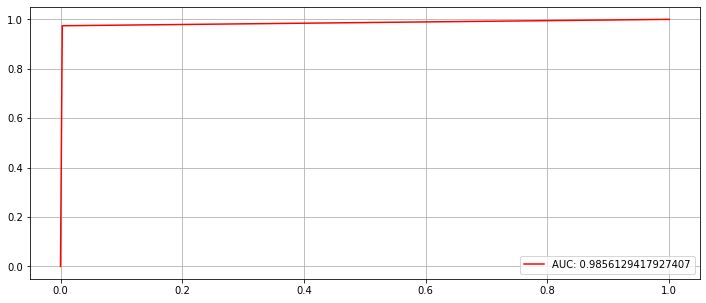

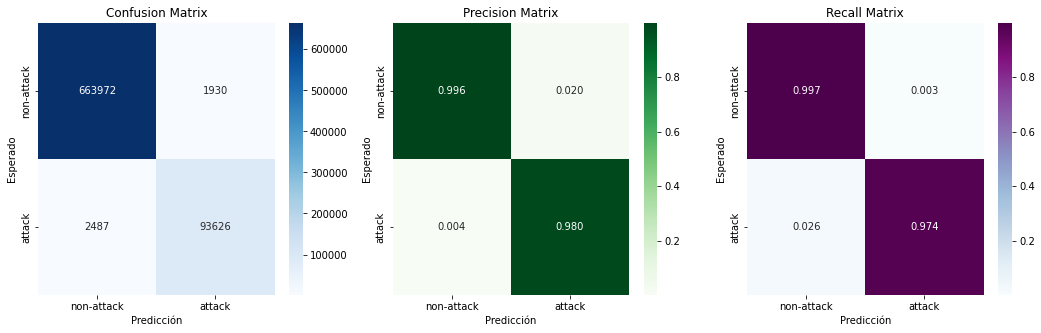

In [15]:
# Resultados con todo el conjunto de datos

auc, f1, far = final_fun_2(x_test, y_test.values)